In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

2024-06-09 21:47:12.407627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_images, train_labels),  (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [3]:
# Combine train and test sets
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Shuffle the combined dataset
indices = np.arange(len(all_images))
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

In [4]:
# Calculate the number of samples for each split
num_total = len(all_images)
num_train = int(0.6 * num_total)
num_val = int(0.2 * num_total)
num_test = num_total - num_train - num_val

# Split the data
train_images = all_images[:num_train]
train_labels = all_labels[:num_train]
val_images = all_images[num_train:num_train + num_val]
val_labels = all_labels[num_train:num_train + num_val]
test_images = all_images[num_train + num_val:]
test_labels = all_labels[num_train + num_val:]

print("Training data shape:", train_images.shape)
print("Validation data shape:", val_images.shape)
print("Test data shape:", test_images.shape)

Training data shape: (36000, 32, 32, 3)
Validation data shape: (12000, 32, 32, 3)
Test data shape: (12000, 32, 32, 3)


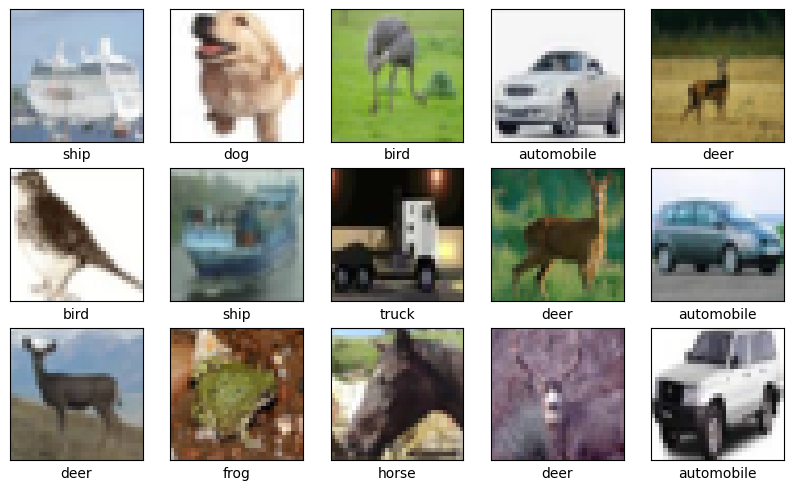

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])

    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [11]:
## Creating the Convolutional Neural Network model 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='leaky_relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.15))
model.add(layers.Conv2D(64, (3, 3), activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.15))

## Neural Network
model.add(layers.Flatten())
model.add(layers.Dense(56, activation='leaky_relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10))

## Display model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                      

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1, mode='auto')

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels), callbacks=[reduce_lr])

Epoch 1/50
1125/1125 [==============================] - 29s 26ms/step - loss: 1.4222 - accuracy: 0.5012 - val_loss: 1.3971 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 2/50
1125/1125 [==============================] - 29s 26ms/step - loss: 1.0833 - accuracy: 0.6237 - val_loss: 1.1183 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 3/50
1125/1125 [==============================] - 30s 27ms/step - loss: 0.9679 - accuracy: 0.6644 - val_loss: 1.3089 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 4/50
1125/1125 [==============================] - 30s 27ms/step - loss: 0.8881 - accuracy: 0.6923 - val_loss: 1.0610 - val_accuracy: 0.6409 - lr: 0.0010
Epoch 5/50
1125/1125 [==============================] - 31s 27ms/step - loss: 0.8354 - accuracy: 0.7100 - val_loss: 1.0596 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 6/50
1125/1125 [==============================] - 31s 27ms/step - loss: 0.7808 - accuracy: 0.7286 - val_loss: 0.9218 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 7/50
1125/1125 [========================

KeyboardInterrupt: 

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen.fit(train_images)

In [10]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=20, validation_data=(val_images, val_labels), 
                    callbacks=[reduce_lr])

Epoch 1/20
 95/563 [====>.........................] - ETA: 25s - loss: 2.0033 - accuracy: 0.0866

KeyboardInterrupt: 

NameError: name 'history' is not defined

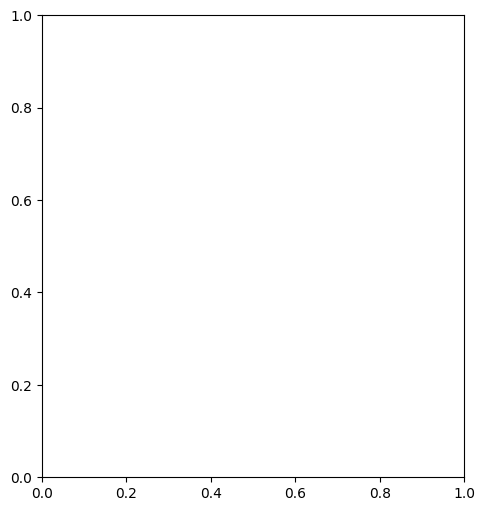

In [14]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_labels.flatten()

375/375 [==============================] - 2s 5ms/step


In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

# Calculate the accuracy score
test_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy Score: {test_accuracy:.3f}")

# Calculate the F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.3f}")

375/375 [==============================] - 2s 6ms/step - loss: 0.8660 - accuracy: 0.7334
Test accuracy: 0.7334166765213013
Test loss: 0.8660443425178528
Accuracy Score: 0.733
F1 Score: 0.733


In [18]:
# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_labels.flatten()

375/375 [==============================] - 2s 6ms/step


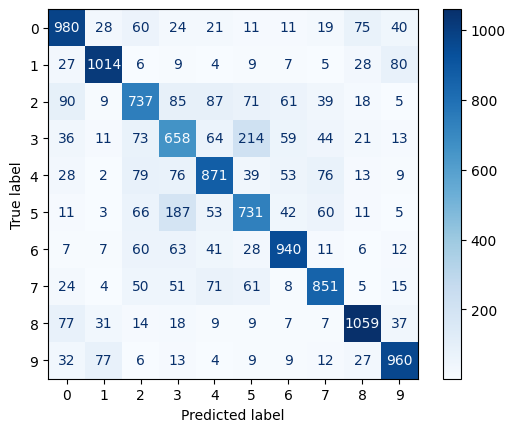

In [19]:
# Compute and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()